In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/EPAM/datasets/predict_future_sales')
GDRIVE_PATH = '/content/drive/MyDrive/EPAM/datasets/predict_future_sales/'

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
import lightgbm
import xgboost
import torch.nn as nn
from importlib import reload
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from functools import reduce
import statistics
import main as tsm
import cross_valid as tscv

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/monthly_sales_train.csv', index_col=None)
items = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/items.csv', index_col='item_id')
items_cat = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/item_categories.csv', index_col='item_category_id')
city = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/city_copy.csv', index_col=None)
shops = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/shops_copy.csv', index_col='shop_id')

In [ ]:
data.head(3)

,shop_id,item_id,date_block_num,item_price,item_cat,city_id,year,month,item_cnt_month,population,mean_shop_price,median_shop_price,mean_item_cnt_month_shop,median_item_cnt_month_shop
0,0,30,0,265.0,40,4,2013,1,0.0,286,436.85233,192.5,1.549444,1.0
1,0,30,1,265.0,40,4,2013,2,31.0,286,433.73575,190.0,1.701944,1.0
2,0,30,2,265.0,40,4,2013,3,0.0,286,433.73575,190.0,0.000000,0.0


In [ ]:
np.any(data.isna())

False

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14420216 entries, 0 to 14420215
Data columns (total 14 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   shop_id                     int64  
 1   item_id                     int64  
 2   date_block_num              int64  
 3   item_price                  float64
 4   item_cat                    int64  
 5   city_id                     int64  
 6   year                        int64  
 7   month                       int64  
 8   item_cnt_month              float64
 9   population                  int64  
 10  mean_shop_price             float64
 11  median_shop_price           float64
 12  mean_item_cnt_month_shop    float64
 13  median_item_cnt_month_shop  float64
dtypes: float64(6), int64(8)
memory usage: 1.5 GB


In [ ]:
columns = ['shop_id','item_id','date_block_num']

In [ ]:
#data.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
data.sort_values(columns, inplace=True)

In [ ]:
data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cat',
       'city_id', 'year', 'month', 'item_cnt_month', 'population',
       'mean_shop_price', 'median_shop_price', 'mean_item_cnt_month_shop',
       'median_item_cnt_month_shop'],
      dtype='object')

In [ ]:
data[['shop_id','date_block_num','city_id','month','item_cat']] = data[['shop_id','date_block_num','city_id','month','item_cat']].astype(np.uint8)

In [ ]:
data[['item_id','year']] = data[['item_id','year']].astype(np.uint16)

In [ ]:
np.iinfo(np.uint16)

iinfo(min=0, max=65535, dtype=uint16)

In [ ]:
max(data['population'])

12108

In [ ]:
data['population'] = data['population'].astype(np.uint16)

In [ ]:
data[['item_cnt_month','item_price']] = data[['item_cnt_month','item_price']].astype(np.float32)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14420216 entries, 0 to 14420215
Data columns (total 14 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   shop_id                     uint8  
 1   item_id                     uint16 
 2   date_block_num              uint8  
 3   item_price                  float32
 4   item_cat                    uint8  
 5   city_id                     uint8  
 6   year                        uint16 
 7   month                       uint8  
 8   item_cnt_month              float32
 9   population                  uint16 
 10  mean_shop_price             float64
 11  median_shop_price           float64
 12  mean_item_cnt_month_shop    float64
 13  median_item_cnt_month_shop  float64
dtypes: float32(2), float64(4), uint16(3), uint8(5)
memory usage: 811.4 MB


In [ ]:
data['mean_shop_price'] = pd.Series(None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
mean_shop_price = data.groupby(['shop_id','date_block_num'])['item_price'].mean()
median_shop_price = data.groupby(['shop_id','date_block_num'])['item_price'].median()
mean_item_cnt_month_shop = data.groupby(['shop_id','date_block_num'])['item_cnt_month'].mean()
median_item_cnt_month_shop = data.groupby(['shop_id','date_block_num'])['item_cnt_month'].median()

#mean_item_cat_price = data.groupby(['item_cat','date_block_num'])['item_price'].mean()
#median_item_cat_price = data.groupby(['item_cat','date_block_num'])['item_price'].median()


In [ ]:
for sid, date in mean_shop_price.index:
    data.loc[(data['shop_id']==sid)&(data['date_block_num']==date),'mean_shop_price'] = mean_shop_price.loc[(sid,date)]

In [ ]:
data['median_shop_price'] = pd.Series(None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
for sid, date in median_shop_price.index:
    data.loc[(data['shop_id']==sid)&(data['date_block_num']==date),'median_shop_price'] = median_shop_price.loc[(sid,date)]

In [ ]:
data['mean_item_cnt_month_shop'] = pd.Series(None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
for sid, date in mean_item_cnt_month_shop.index:
    data.loc[(data['shop_id']==sid)&(data['date_block_num']==date),'mean_item_cnt_month_shop'] = mean_item_cnt_month_shop.loc[(sid,date)]

In [ ]:
data['median_item_cnt_month_shop'] = pd.Series(None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
for sid, date in median_item_cnt_month_shop.index:
    data.loc[(data['shop_id']==sid)&(data['date_block_num']==date),'median_item_cnt_month_shop'] = median_item_cnt_month_shop.loc[(sid,date)]

In [ ]:
data[['mean_shop_price','median_shop_price','mean_item_cnt_month_shop','median_item_cnt_month_shop']] = data[['mean_shop_price','median_shop_price','mean_item_cnt_month_shop','median_item_cnt_month_shop']].astype(np.float32)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14420216 entries, 0 to 14420215
Data columns (total 14 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   shop_id                     uint8  
 1   item_id                     uint16 
 2   date_block_num              uint8  
 3   item_price                  float32
 4   item_cat                    uint8  
 5   city_id                     uint8  
 6   year                        uint16 
 7   month                       uint8  
 8   item_cnt_month              float32
 9   population                  uint16 
 10  mean_shop_price             float32
 11  median_shop_price           float32
 12  mean_item_cnt_month_shop    float32
 13  median_item_cnt_month_shop  float32
dtypes: float32(6), uint16(3), uint8(5)
memory usage: 591.3 MB


In [ ]:
data

In [ ]:
data.to_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/monthly_sales_train.csv',index_label=None, index=None)

In [ ]:
np.finfo(np.float16)

finfo(resolution=0.001, min=-6.55040e+04, max=6.55040e+04, dtype=float16)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


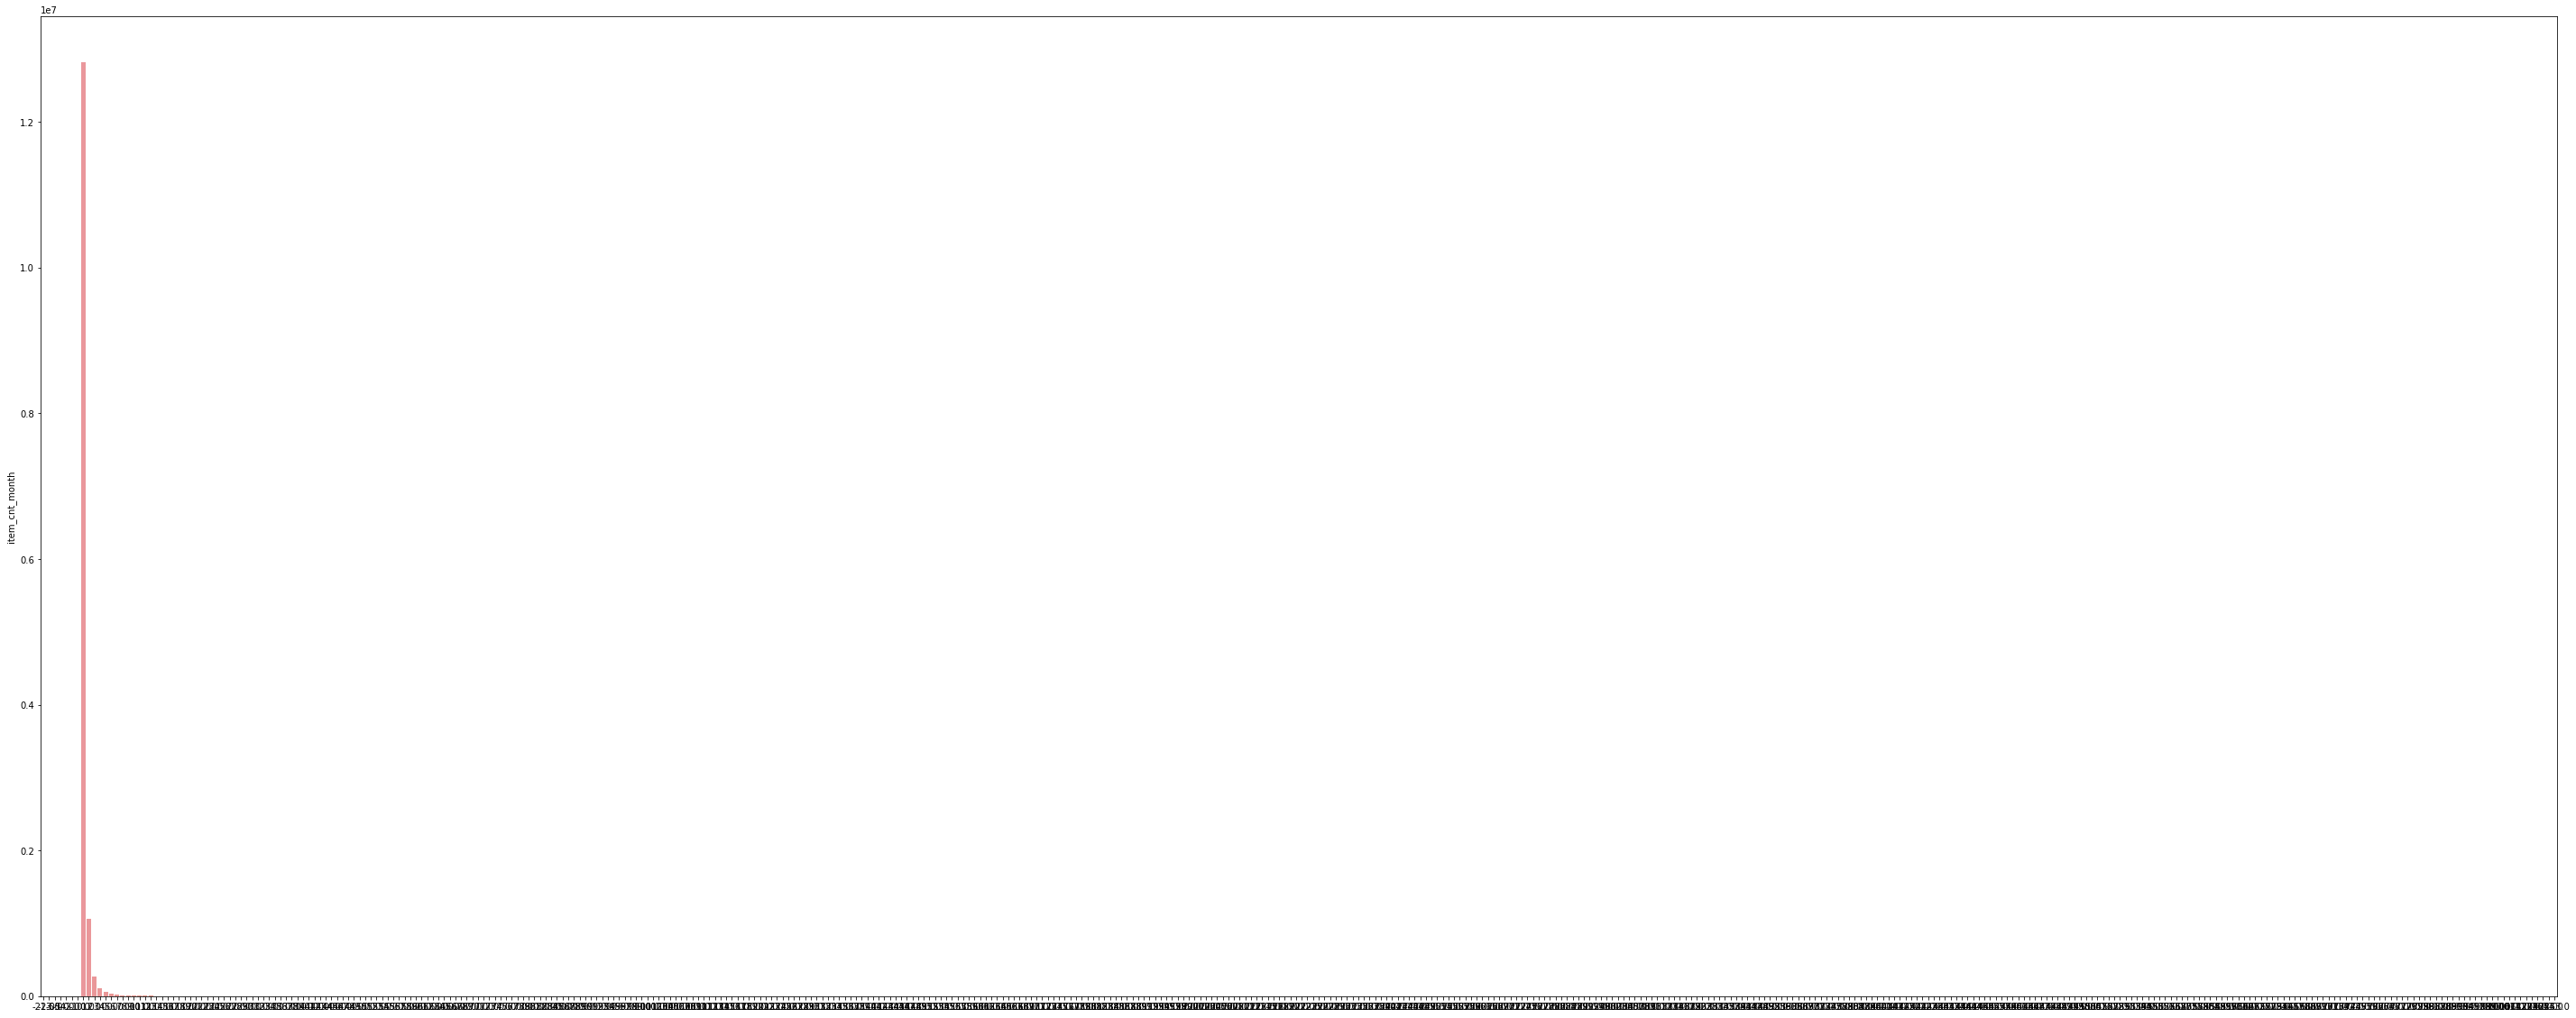

In [ ]:
rcParams['figure.figsize'] = 50,20
sns.barplot(data['item_cnt_month'].value_counts().index, data['item_cnt_month'].value_counts())

In [ ]:
from scipy.stats import kstest
from scipy.stats import laplace

In [ ]:
def mean_median_deviation(x):
    return np.mean(np.abs(x-np.median(x)))

In [ ]:
mean_median_deviation(data['item_cnt_month'])

0.25312963128089905

(array([8.329795e+06, 1.596382e+06, 5.989000e+03, 1.421000e+03,
        6.590000e+02, 3.390000e+02, 2.220000e+02, 1.260000e+02,
        8.700000e+01, 6.600000e+01, 4.900000e+01, 3.200000e+01,
        2.800000e+01, 1.800000e+01, 2.500000e+01, 1.200000e+01,
        1.200000e+01, 1.600000e+01, 7.000000e+00, 1.000000e+01,
        1.100000e+01, 1.000000e+01, 9.000000e+00, 5.000000e+00,
        7.000000e+00, 9.000000e+00, 8.000000e+00, 9.000000e+00,
        7.000000e+00, 3.000000e+00, 2.000000e+00, 4.000000e+00,
        1.000000e+00, 5.000000e+00, 8.000000e+00, 4.000000e+00,
        3.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        4.000000e+00, 0.000000e+00, 2.000000e+00, 1.000000e+00,
        3.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

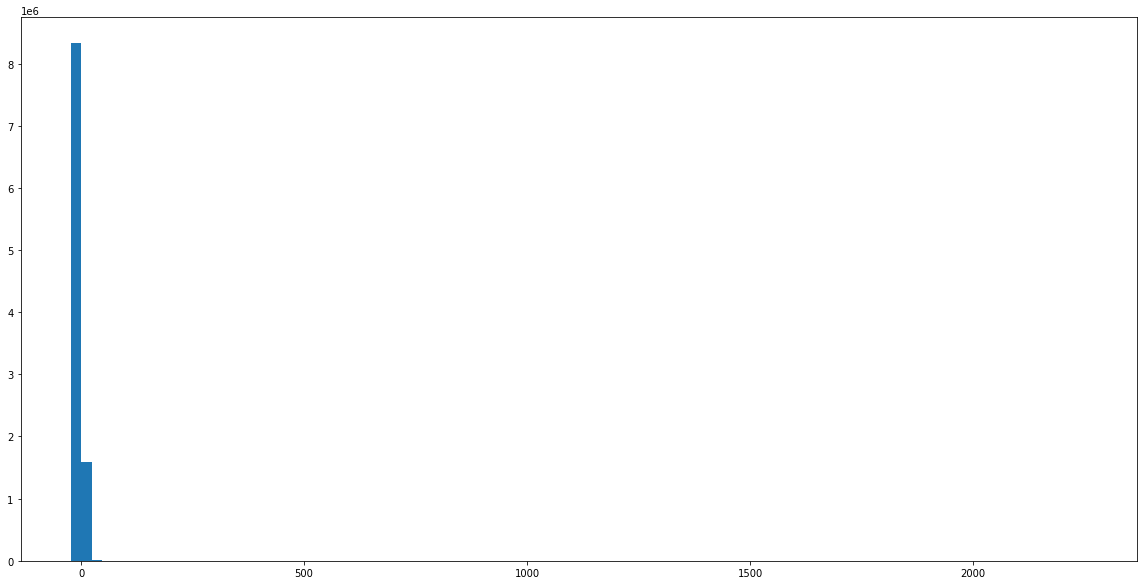

In [ ]:
rcParams['figure.figsize'] = 20, 10
plt.hist(data['item_cnt_month'], bins = 100)

In [ ]:
data.set_index(columns,inplace=True)

KeyError: ignored

In [ ]:
data.index = data['date_block_num']

KeyError: ignored

In [ ]:
temp = data.groupby(columns[:2])['item_cnt_month'].rolling(3).mean()

shop_id  item_id
0        30               NaN
         30               NaN
         30         10.333333
         30         10.333333
         30          0.000000
                      ...    
59       22167       0.000000
         22167       0.000000
         22167       0.000000
         22167       0.000000
         22167       0.000000
Name: item_cnt_month, Length: 14420216, dtype: float64

In [ ]:
items

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40
...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",31
22166,Язык запросов 1С:Предприятия [Цифровая версия],54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49


In [ ]:
city.loc[data.groupby(['city_id'])['item_cnt_month'].max().sort_values().index]

,city,2013,2014,2015
city_id,,,,
8,Мытищи,179,183,187
24,Жуковский,107,108,108
3,Самара,1172,1172,1172
2,Ярославль,599,602,604
17,Адыгея,444,444,444
15,Вологда,306,308,311
1,Курск,429,431,435
6,Балашиха,235,247,261
20,Новосибирск,1524,1548,1567


In [ ]:
#data['item_cnt_month'].to_numpy()

array([31.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [ ]:
tsm.RMSE(data['item_cnt_month'].to_numpy(),data['item_cnt_month'].to_numpy()-data['item_cnt_month'].to_numpy())

3.5986488